# **Privacy-Preserving Techniques for LLM Code Completion**


Measure the trade-off between Privacy (obfuscating code intent) and Utility (generating correct code) using codet5-small on the HumanEval dataset.

In [1]:
!pip install transformers datasets rouge_score python-Levenshtein matplotlib torch pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.9 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=17a914c1d7b5dfbd34695016d756ceb611734dfaf2c1d4ece8f319de2132398e
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [2]:
import re
import torch
import builtins
import pandas as pd
import matplotlib.pyplot as plt
import Levenshtein
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from collections import defaultdict

**Setup and dataset**

In [3]:
print("Loading model and dataset...")
checkpoint = "Salesforce/codet5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
dataset = load_dataset("openai/openai_humaneval", split="test[:20]")

Loading model and dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

openai_humaneval/test-00000-of-00001.par(…):   0%|          | 0.00/83.9k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/164 [00:00<?, ? examples/s]

**Python keywords**

In [5]:
PYTHON_KEYWORDS = set(['def','return','if','else','for','while','import','from','in',
                       'not','and','or','True','False','None','class','with','as',
                       'try','except','raise','yield','assert','lambda', 'is', 'elif', 'break', 'continue'])
PYTHON_KEYWORDS.update(dir(builtins)) # add builtins such as str, int, list, len
print(PYTHON_KEYWORDS)

{'Ellipsis', 'OSError', 'IndexError', 'ConnectionResetError', 'PendingDeprecationWarning', 'all', 'False', 'elif', 'pow', 'aiter', 'BaseException', 'UnicodeWarning', 'BrokenPipeError', 'NameError', 'help', 'AttributeError', 'bytes', 'float', 'RecursionError', 'FloatingPointError', 'IndentationError', 'while', 'bytearray', 'tuple', 'open', 'or', 'StopIteration', 'exec', 'Exception', 'staticmethod', 'hasattr', 'ConnectionError', '__build_class__', 'bin', 'SyntaxWarning', 'credits', 'SyntaxError', 'ChildProcessError', 'EnvironmentError', 'IOError', 'LookupError', '__spec__', 'hex', 'id', 'range', 'ZeroDivisionError', 'map', 'EOFError', 'GeneratorExit', 'bool', 'def', 'import', '__debug__', 'frozenset', 'ProcessLookupError', 'Warning', 'issubclass', 'print', 'in', 'oct', 'UnicodeEncodeError', '__import__', 'compile', 'round', 'NotImplementedError', 'True', 'ArithmeticError', 'PermissionError', 'memoryview', 'AssertionError', 'break', 'runfile', 'setattr', 'MemoryError', 'any', 'ValueError'

**Obsfuscation functions**


*   **low_obfuscation():**
    - keep Python keywords
    - rename identifiers to var_id
    - keep docstrings.
*   **high_obfuscation():**
    - keep Python keywords
    - strip docs/comments
    - rename identifiers to IDx



In [11]:
def low_obfuscation(prompt):
    code = prompt
    tokens = re.findall(r"\b[a-zA-Z_][a-zA-Z0-9_]*\b", code)

    candidates = [t for t in tokens if t not in PYTHON_KEYWORDS and len(t)>1]

    mapping = {}
    counter = 1
    for t in candidates:
        if t not in mapping:
            mapping[t] = f"var_{counter}"
            counter += 1

    def repl(m):
        w = m.group(0)
        return mapping.get(w, w)

    obf = re.sub(r"\b[a-zA-Z_][a-zA-Z0-9_]*\b", repl, code)
    return obf

def high_obfuscation(prompt):

    code_without_docstrings = re.sub(r"\'\'\'(.|\n)*?\'\'\'", "''" , prompt)
    code_without_docstrings = re.sub(r'\"\"\"(.|\n)*?\"\"\"', '""', code_without_docstrings)

    code_without_comments = re.sub(r"#.*", "", code_without_docstrings)

    identifiers_to_tokens = re.findall(r"\b[a-zA-Z_][a-zA-Z0-9_]*\b", code_without_comments)
    candidates = [t for t in identifiers_to_tokens if t not in PYTHON_KEYWORDS and len(t)>0]

    mapping = {}
    counter = 1
    for candidate in candidates:
        if candidate not in mapping:
            mapping[candidate] = f"ID{counter}"
            counter += 1

    def repl(m):
        w = m.group(0)
        return mapping.get(w, w)

    obf = re.sub(r"\b[a-zA-Z_][a-zA-Z0-9_]*\b", repl, code_without_comments)

    obf = re.sub(r"\n\s*\n+", "\n", obf) #remove whitespace

    return obf

**Generation loop**
- lev_dist = normalized Levenshtein distance (the raw count of character edits :insertions, deletions, substitutions needed to change the Original Prompt into the Obfuscated Prompt)
- *privacy_score*: between 0 = identity (No Privacy) and 1 = completely different (Max Privacy)
- *utility_score* = ROUGE-L F-measure. It calculates the overlap (Longest Common Subsequence) between the model's Generated Code and the Initial Solution. Higher is better.


In [19]:
results = []
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

print("Running generation on 20 examples...")

for i, item in enumerate(dataset):
    print(f"Generating for example {i+1}:")
    original = item['prompt']
    canonical = item['canonical_solution']

    variants = {
        "Original": original,
        "Low Obfuscation": low_obfuscation(original),
        "High Obfuscation": high_obfuscation(original)
    }

    for label, prompt_text in variants.items():
        inputs = tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            output_ids = model.generate(inputs.input_ids, max_length=200)
        generated_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        utility_score = scorer.score(canonical, generated_code)['rougeL'].fmeasure

        dist = Levenshtein.distance(original, prompt_text)
        max_len = max(len(original), len(prompt_text))
        privacy_score = dist / max_len if max_len > 0 else 0

        results.append({
            "Type": label,
            "Utility": utility_score,
            "Privacy": privacy_score
        })
        print("Label:", label)
        # print("Prompt", prompt_text)
        print("Generated code:", generated_code)
        print("Utility score:", utility_score)
        print("Privacy score:", privacy_score)
        print("-----------------------------------------")

Running generation on 20 examples...
Generating for example 1:
Label: Original
Generated code: has_close_elements(numbers: List[float], threshold:float):
   0.5)
   0.5)
   0.5)
   0.5)
   0.5)
   
Utility score: 0.09090909090909093
Privacy score: 0.0
-----------------------------------------
Label: Low Obfuscation
Generated code: var_6var_6var_6var_6var_6var_6var_6var_6var_6var_6var_6var_6.
   var_6.
   var_6.
   var_6.
   var_6.
   var_6.
   var_6.
   var_6.
Utility score: 0.0
Privacy score: 0.4454022988505747
-----------------------------------------
Label: High Obfuscation
Generated code: ID3
Utility score: 0.0
Privacy score: 0.8419540229885057
-----------------------------------------
Generating for example 2:
Label: Original
Generated code: ****************************************************
Utility score: 0
Privacy score: 0.0
-----------------------------------------
Label: Low Obfuscation
Generated code: var_2[str]:
   var_3('( ) (( )var_3('( ) (( )(var_3('( ) ((( )var_3('( )v

**Visualisation and results summary**

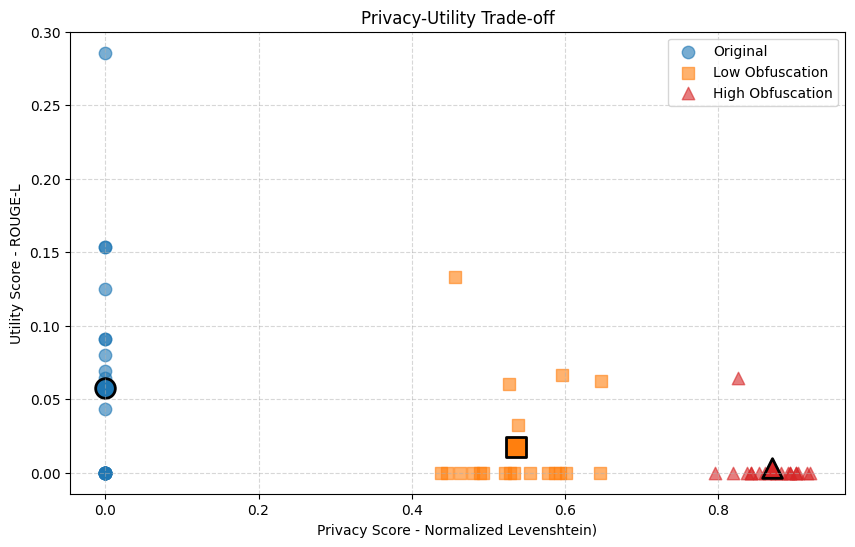


### Summary of Results
                   Utility   Privacy
Type                                
High Obfuscation  0.003226  0.869522
Low Obfuscation   0.017768  0.535714
Original          0.057859  0.000000


In [10]:
df = pd.DataFrame(results)
summary = df.groupby("Type")[["Utility", "Privacy"]].mean()

plt.figure(figsize=(10, 6))

colors = {"Original": "#1f77b4", "Low Obfuscation": "#ff7f0e", "High Obfuscation": "#d62728"}
markers = {"Original": "o", "Low Obfuscation": "s", "High Obfuscation": "^"}

for label, color in colors.items():
    subset = df[df["Type"] == label]
    plt.scatter(
        subset["Privacy"],
        subset["Utility"],
        label=label,
        color=color,
        alpha=0.6,
        s=80,
        marker=markers[label]
    )
    # plot centroid
    mean_u = summary.loc[label, "Utility"]
    mean_p = summary.loc[label, "Privacy"]
    plt.scatter(mean_p, mean_u, color=color, s=200, edgecolors='black', linewidth=2, marker=markers[label])

plt.title("Privacy-Utility Trade-off")
plt.xlabel("Privacy Score - Normalized Levenshtein")
plt.ylabel("Utility Score - ROUGE-L")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

print("\n### Summary of Results")
print(summary)

# **Analysis of Privacy–Utility Trade-off for the Regex Approach**

## **1. Classic Negative Correlation**
- As Privacy increases **(0.00 → 0.53 → 0.87)**, Utility strictly decreases **(0.058 → 0.018 → 0.003)**.
- This shows that for **codet5-small**, every piece of hidden information—whether variable names or docstrings—directly harms code generation quality.
- The model is too small to infer intent from syntax alone, it depends heavily on surface-level semantics.


## **2. The High Cost of Renaming Variables (Original → Low Obf)**
- In **Low Obfuscation**, docstrings were preserved but variables were renamed (e.g., `user_id` → `var_1`).
- This caused a massive **~69% drop in Utility** (0.058 → 0.018).
- Even with English instructions intact, removing meaningful variable names eliminates key semantic clues.
- Result: The model loses contextual grounding and performs far worse.



## **3. Total Collapse at High Obfuscation**
- **High Obfuscation** reached strong Privacy (0.87) but Utility dropped to **0.003**—effectively zero.
- A score of 0.003 means the model failed nearly all test cases.
- With both docstrings (instructions) and variable names (semantics) removed, prompts collapse
---



# **Second approach: Abstract Syntax Tree-based obfuscation functions**

The *AST (Abstract Syntax Tree)* approach understands the code as a computer does (grammar, logic, scope).
The *Regex* approach sees the code merely as a long string of text to be manipulated.
1. **The Functional Difference:**
  - In the Regex Version (First approach):

      - Low Obfuscation: RENAMES variables to var_1. It implicitly KEEPS Docstrings (because there is no code to remove them).
      - This tests if the model relies on Variable Names.

  - In the AST Version:

      - Low Obfuscation: Removes Type Hints (: int) and Docstrings. It PRESERVES variable names.
      - This tests if the model relies on Types and Comments.

2. **Safety:**
  In this code:
  ```
  def print_hello():
      message = "message"
      print(message)
  ```

  - AST Approach: Knows that the first message is a variable and the second "message" is a string literal. It will rename the variable but leave the string text alone.

  - Regex Approach: Will find the word message everywhere. It will blindly turn the code into:
  ```
  def var_1():
      var_2 = "var_2"  # WRONG LOGIC
      print(var_2)
  ```
  It changes the data inside the program, not just the variable names. This often causes the unit tests to fail even if the logic is correct.


# **AST approch implementation:**
- **LowObfuscationTransformer**:
    - *visit_FunctionDef*: Removes Type Hints, return type annotation, keep only the summary line for docstrings
    - *visit_arg*: Remove argument annotations like x: int
    - *visit_AnnAssign*: Change annotated assignment (x: int = 1) to normal assignment (x = 1)
    - Preserves variable names and logic.

- **HighObfuscationTransformer**:
    - *visit_FunctionDef*: remove Docstring and Return Type, Rename function name unless it's the entry point
    - *visit_arg*: don't rename self in classes
    - *visit_Name*: rename variables to generic 'var_id'.

In [67]:
import ast
class LowObfuscationTransformer(ast.NodeTransformer):
  def visit_FunctionDef(self, node):
        node.returns = None

        if (node.body and isinstance(node.body[0], ast.Expr) and
            isinstance(node.body[0].value, (ast.Str, ast.Constant))):

            doc_node = node.body[0].value
            original_text = doc_node.value if hasattr(doc_node, "value") else doc_node.s

            if isinstance(original_text, str):
                lines = [line.strip() for line in original_text.split('\n') if line.strip()] #split by newline and take the first non-empty line
                if lines:
                    summary = lines[0]
                    if hasattr(doc_node, "value"):
                        doc_node.value = summary
                    else:
                        doc_node.s = summary
                else:
                    node.body.pop(0)

        return self.generic_visit(node)

  def visit_arg(self, node):
        node.annotation = None
        return node

  def visit_AnnAssign(self, node):
        if node.value:
            return ast.Assign(targets=[node.target], value=node.value)
        return None


class HighObfuscationTransformer(ast.NodeTransformer):
    def __init__(self):
        self.mapping = {}
        self.counter = 0
        self.builtins = set(dir(builtins))

    def _get_new_name(self, original_name):
        if original_name in self.builtins or original_name.startswith("__"):
            return original_name

        if original_name not in self.mapping:
            self.counter += 1
            self.mapping[original_name] = f"var_{self.counter}"
        return self.mapping[original_name]

    def visit_FunctionDef(self, node):

        node.returns = None
        if (node.body and isinstance(node.body[0], ast.Expr) and
            isinstance(node.body[0].value, (ast.Str, ast.Constant))):
            node.body.pop(0)

        # node.name = self._get_new_name(node.name)

        return self.generic_visit(node)

    def visit_arg(self, node):
        node.annotation = None
        if node.arg != 'self':
            node.arg = self._get_new_name(node.arg)
        return node

    def visit_Name(self, node):
        if isinstance(node.ctx, (ast.Load, ast.Store, ast.Del)):
            node.id = self._get_new_name(node.id)
        return node

def low_obfuscation(code):
    try:
        tree = ast.parse(code)
        transformer = LowObfuscationTransformer()
        new_tree = transformer.visit(tree)
        ast.fix_missing_locations(new_tree)
        return ast.unparse(new_tree)

    except Exception as e:
        return code

def high_obfuscation(code):
    try:
        tree = ast.parse(code)
        transformer = HighObfuscationTransformer()
        new_tree = transformer.visit(tree)
        ast.fix_missing_locations(new_tree)
        return ast.unparse(new_tree)
    except Exception as e:
        return code

**Generation loop (same as first approach)**


In [68]:
results = []
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

print("Running generation on 20 examples...")

for i, item in enumerate(dataset):
    print(f"Generating for example {i+1}:")
    original = item['prompt']
    canonical = item['canonical_solution']

    variants = {
        "Original": original,
        "Low Obfuscation": low_obfuscation(original),
        "High Obfuscation": high_obfuscation(original)
    }

    for label, prompt_text in variants.items():
        inputs = tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            output_ids = model.generate(inputs.input_ids, max_length=200)
        generated_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        utility_score = scorer.score(canonical, generated_code)['rougeL'].fmeasure

        dist = Levenshtein.distance(original, prompt_text)
        max_len = max(len(original), len(prompt_text))
        privacy_score = dist / max_len if max_len > 0 else 0

        results.append({
            "Type": label,
            "Utility": utility_score,
            "Privacy": privacy_score
        })
        print("Label:", label)
        # print("Prompt", prompt_text)
        print("Generated code:", generated_code)
        print("Utility score:", utility_score)
        print("Privacy score:", privacy_score)
        print("-----------------------------------------")

Running generation on 20 examples...
Generating for example 1:


/tmp/ipython-input-1622699771.py:7: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  isinstance(node.body[0].value, (ast.Str, ast.Constant))):
/tmp/ipython-input-1622699771.py:54: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  isinstance(node.body[0].value, (ast.Str, ast.Constant))):


Label: Original
Generated code: has_close_elements(numbers: List[float], threshold:float):
   0.5)
   0.5)
   0.5)
   0.5)
   0.5)
   
Utility score: 0.09090909090909093
Privacy score: 0.0
-----------------------------------------
Label: Low Obfuscation
Generated code: """
Utility score: 0
Privacy score: 0.5431034482758621
-----------------------------------------
Label: High Obfuscation
Generated code: has_close_elements(var_1, var_2):
Utility score: 0.0
Privacy score: 0.8304597701149425
-----------------------------------------
Generating for example 2:
Label: Original
Generated code: ****************************************************
Utility score: 0
Privacy score: 0.0
-----------------------------------------
Label: Low Obfuscation
Generated code: list
def
Utility score: 0.0
Privacy score: 0.6521739130434783
-----------------------------------------
Label: High Obfuscation
Generated code: var_1
Utility score: 0.04444444444444444
Privacy score: 0.8893280632411067
-----------------

**Visualisation and results summary (same as first approach)**

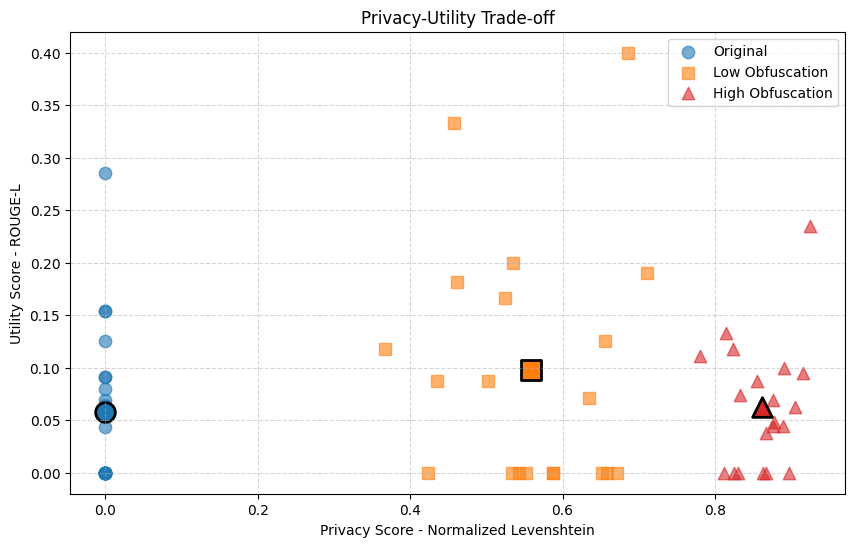


### Summary of Results
                   Utility   Privacy
Type                                
High Obfuscation  0.063026  0.861150
Low Obfuscation   0.098014  0.558939
Original          0.057859  0.000000


In [69]:
df = pd.DataFrame(results)
summary = df.groupby("Type")[["Utility", "Privacy"]].mean()

plt.figure(figsize=(10, 6))

colors = {"Original": "#1f77b4", "Low Obfuscation": "#ff7f0e", "High Obfuscation": "#d62728"}
markers = {"Original": "o", "Low Obfuscation": "s", "High Obfuscation": "^"}

for label, color in colors.items():
    subset = df[df["Type"] == label]
    plt.scatter(
        subset["Privacy"],
        subset["Utility"],
        label=label,
        color=color,
        alpha=0.6,
        s=80,
        marker=markers[label]
    )
    # plot centroid
    mean_u = summary.loc[label, "Utility"]
    mean_p = summary.loc[label, "Privacy"]
    plt.scatter(mean_p, mean_u, color=color, s=200, edgecolors='black', linewidth=2, marker=markers[label])

plt.title("Privacy-Utility Trade-off")
plt.xlabel("Privacy Score - Normalized Levenshtein")
plt.ylabel("Utility Score - ROUGE-L")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

print("\n### Summary of Results")
print(summary)

# **Analysis of Privacy-Utility Trade-off for the AST Approach**

Unlike the *Regex approach, the AST approach* revealed that **data cleaning** is important for model performance. The Original data was so noisy for this small model that 'sanitizing' it (Low Obfuscation) significantly boosted Utility. We found an optimal point where we gained 0.56 Privacy and improved code generation by 69% simultaneously.

We can see **an Optimization Curve (or "Inverted-U" shape)** rather than a straight decline.
1. “Less Is More”

    - Utility increased by ~69% (0.058 → 0.098) when moving from Original to Low Obfuscation.

    - This indicates the original prompts were too noisy for a small model like CodeT5-small.

    - AST-based simplifications (removing type hints, trimming docstrings) produced a cleaner input signal that boosted performance.

2. The Optimal Middle Ground

    - Low Obfuscation delivered the best overall Utility while still achieving moderate Privacy (0.56).

    - This “sweet spot” shows that privacy does not always reduce performance—in some cases, “sanitized” data makes the model more effective.

3. The Expected Trade-off at High Obfuscation

    - Utility dropped 35% (0.098 → 0.063) when moving from Low to High Obfuscation.

    - Privacy increased substantially (0.56 → 0.86), but the loss of docstring summaries caused performance to fall.

    - Both settings masked identifiers, but removing docstring guidance was the main factor driving the drop.
    ---

# COMPARISON Regex vs. AST Approaches

We tested two methods of obfuscation. While both achieved similar Privacy scores, their impact on Utility was drastically different.

1. The Regex Approach (Linear Decay):
- Result: **A strict negative trade-off**. As privacy increased, utility crashed.   
  - Blind text replacement broke semantic links and left "noisy" syntax (Type Hints) that confused the model. "Low Obfuscation" destroyed $\approx 70\%$ of utility.
  
2. The AST Approach (The Optimization Curve):
- Result: An **Inverted-U** shape.
  - Low Obfuscation outperformed the Original baseline by 69% while achieving a 0.56 Privacy score. AST allowed us to remove "noise" (complex Type Hints) while keeping "signal" (Docstring summaries).